[*********************100%***********************]  1 of 1 completed

  Ticker  Aktienkurs  Strike  Laufzeit (Jahre)  Zinssatz  Volatilität  \
0   AAPL      227.63     210          2.353425      0.05     0.289737   

   Berechneter Call-Preis  Marktpreis Call-Option  
0               60.398726                    55.0  


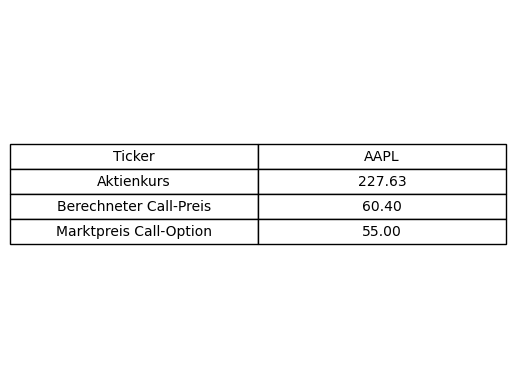

In [3]:
import sys
import subprocess

# pip aktualisieren
subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "pip"])

# Fehlende Module automatisch installieren
def install_and_import(package):
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        __import__(package)

install_and_import("numpy")
install_and_import("pandas")
install_and_import("yfinance")
install_and_import("scipy")
install_and_import("matplotlib")
install_and_import("requests")

import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm
import matplotlib.pyplot as plt
from datetime import datetime
import requests

def get_historical_volatility(ticker, days=30):
    data = yf.download(ticker, period=f'{days}d', interval='1d')
    if data.empty:
        raise ValueError(f"Keine historischen Daten für {ticker} verfügbar.")
    close_column = 'Adj Close' if 'Adj Close' in data.columns else 'Close'
    log_returns = np.log(data[close_column] / data[close_column].shift(1)).dropna()
    volatility = log_returns.std() * np.sqrt(252)
    return float(volatility.iloc[0])

def black_scholes(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return float(price)

def calculate_time_to_expiry(current_date, expiry_date):
    current_date = datetime.strptime(current_date, "%Y-%m-%d")
    expiry_date = datetime.strptime(expiry_date, "%Y-%m-%d")
    return (expiry_date - current_date).days / 365

def get_risk_free_rate(years):
    try:
        url = "https://api.stlouisfed.org/fred/series/observations?series_id=DGS10&api_key=YOUR_API_KEY&file_type=json"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            observations = data.get("observations", [])
            if observations:
                latest_rate = float(observations[-1]["value"]) / 100
                return latest_rate
    except Exception as e:
        print(f"Fehler beim Abrufen des risikofreien Zinssatzes: {e}")
    return 0.05  # Fallback-Zinssatz falls API nicht verfügbar ist

# Parameter-Eingabe
TICKER = "AAPL"
S = 227.63  # Manuell eingegebener Aktienkurs
K = 210  # Strike-Preis
CURRENT_DATE = "2025-02-08"  # Aktuelles Datum (YYYY-MM-DD)
EXPIRY_DATE = "2027-06-17"  # Ausführungsdatum (YYYY-MM-DD)
T = calculate_time_to_expiry(CURRENT_DATE, EXPIRY_DATE)
r = get_risk_free_rate(T)  # Dynamischer risikofreier Zinssatz
sigma = get_historical_volatility(TICKER)

# Manuelle Eingabe des Marktpreises
market_call_price = 55.0  # Manuell eingegebener Marktpreis der Call-Option

# Optionspreis berechnen
call_price = black_scholes(S, K, T, r, sigma)

# Ergebnisse anzeigen
data = pd.DataFrame({
    "Ticker": [TICKER],
    "Aktienkurs": [S],
    "Strike": [K],
    "Laufzeit (Jahre)": [T],
    "Zinssatz": [r],
    "Volatilität": [sigma],
    "Berechneter Call-Preis": [call_price],
    "Marktpreis Call-Option": [market_call_price]
})

print(data)

# Übersichtlicher Monitor mit Matplotlib
def plot_monitor(ticker, S, call_price, market_price):
    fig, ax = plt.subplots()
    ax.axis('off')
    table_data = [["Ticker", ticker],
                  ["Aktienkurs", f"{S:.2f}"],
                  ["Berechneter Call-Preis", f"{call_price:.2f}"],
                  ["Marktpreis Call-Option", f"{market_price:.2f}"]]
    table = ax.table(cellText=table_data, loc='center', cellLoc='center')
    table.scale(1, 1.5)
    plt.show()

plot_monitor(TICKER, S, call_price, market_call_price)


In [5]:
"Nasdaq Options Chain"